In [ ]:
!pip install seaborn --upgrade


In [ ]:
!pip install pytorch_forecasting

In [11]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import timedelta
import math


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from sagemaker import image_uris


In [12]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [13]:
sagemaker_session = sagemaker.Session()


In [14]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_bucket_prefix = (
    "deepar-retail-notebook"  # prefix used for all data stored within the bucket
)
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    s3_prefix = s3_bucket_prefix

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [15]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [16]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)


[05/09/25 23:59:06] INFO     Same images used for training and inference. Defaulting to image     ]8;id=288389;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=256787;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=709570;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=776646;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [17]:
online_retail_df = pd.read_json('online_retail.json')
online_retail_df



,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


In [18]:
def human_format(num):
  """Convert a number to a human readable version, e.g. 10M for 10,000,000."""
  if num == 0:
    return '0'
  letters = ["", "K", "M", "B", "T"]
  scale = math.floor(math.log10(abs(num)) / 3)
  # Convert to string: truncate to scale, remove trailing zeros and decimal points
  num = float('{:.3g}'.format(num)) / 10**(3*scale)
  num_str = str(num).rstrip('0').rstrip('.')
  # Append scale letter
  return f'{num_str}{letters[int(scale)]}'
def mpl_human_format(x, pos):
  """Formatter for matplotlib to use human_format."""
  if pos is not None:
    return human_format(x)
  return ''
def make_axes_human_readable(ax, axis="y"):
  """Apply human readable formatting to the specified axis of a matplotlib axes object."""
  if axis.lower() == 'x':
    axisvar = ax.xaxis
  elif axis.lower() == 'y':
    axisvar = ax.yaxis
  else:
    raise ValueError("Must specify axis as either 'x' or 'y'")

  axisvar.set_major_formatter(ticker.FuncFormatter(mpl_human_format))
  return ax

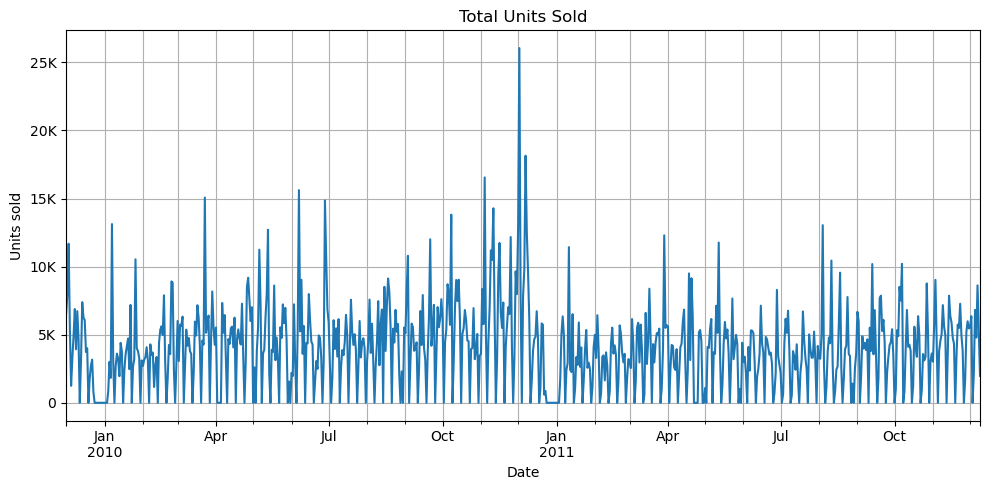

In [19]:
fig, ax = plt.subplots(figsize=(10,5))

online_retail_df.groupby('Date')['UnitsSold'].sum().plot(ax=ax)

ax.set_title('Total Units Sold')
ax.set_xlabel('Date')
ax.set_ylabel('Units sold')
ax.grid(True, which='both')
make_axes_human_readable(ax)

plt.tight_layout()
plt.show()

# Prepare the dataset


In [20]:
formatted_df = online_retail_df.rename(columns={
    'Description': 'ProductId'
})
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df.loc[:,'TimeIdx'] = formatted_df.groupby("ProductId").cumcount()
formatted_df = formatted_df[['Date','TimeIdx', 'ProductId', 'UnitsSold']].reset_index()
formatted_df['UnitsSold'] = formatted_df['UnitsSold'].astype(float)
formatted_df


,index,Date,TimeIdx,ProductId,UnitsSold
0,0,2009-12-01,0,12 pencils small tube red spotty,45.0
1,739,2009-12-01,0,12 pencils tall tube posy,69.0
2,1478,2009-12-01,0,12 pencils tall tube woodland,4.0
3,2217,2009-12-01,0,6 ribbons rustic charm,27.0
4,2956,2009-12-01,0,60 teatime fairy cake cases,173.0
...,...,...,...,...,...
104933,104198,2011-12-09,738,wooden rounders garden set,0.0
104934,102720,2011-12-09,738,wooden school colouring set,13.0
104935,74638,2011-12-09,738,woodland charlotte bag,40.0
104936,75377,2011-12-09,738,world war 2 gliders asstd designs,49.0


In [21]:
from gluonts.dataset.common import ListDataset
import pandas as pd

# Set frequency – assume daily data
freq = "D"

# Split point for training/validation
train_end_date = formatted_df['Date'].max() - pd.Timedelta(days=30)

# Create train and test series
train_series = []
test_series = []

for product_id, df_group in formatted_df.groupby("ProductId"):
    df_group = df_group.sort_values("Date")

    # Full series
    start = pd.Timestamp(df_group["Date"].iloc[0])
    target = df_group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    scale = max(target) if max(target) > 0 else 1
    # Split for training
    train_df = df_group[df_group["Date"] <= train_end_date]
    test_df = df_group

    train_len = len(train_df)
    # Add to lists
    if len(train_df) >= 30:  # Ensure sufficient history for DeepAR
        train_series.append({
            "start": pd.Timestamp(train_df["Date"].iloc[0]).strftime("%Y-%m-%d"),
            "target": target_log[:train_len].tolist(),
            "item_id": str(product_id),
            #"scale": scale
        })
        test_series.append({
            "start": pd.Timestamp(test_df["Date"].iloc[0]).strftime("%Y-%m-%d"),
            "target": target_log.tolist(),
            "item_id": str(product_id),
            #"scale": scale
        })


In [22]:
import json

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        f.write(json.dumps(record) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        f.write(json.dumps(record) + "\n")

In [23]:
df = pd.read_json("test.json", lines=True)
df

,start,target,item_id
0,2009-12-01,"[3.828641396489095, 4.477336814478206, 3.55534...",12 pencils small tube red spotty
1,2009-12-01,"[4.2484952420493585, 4.477336814478206, 4.7621...",12 pencils tall tube posy
2,2009-12-01,"[1.6094379124341, 3.091042453358315, 2.6390573...",12 pencils tall tube woodland
3,2009-12-01,"[3.3322045101752042, 2.079441541679835, 1.3862...",6 ribbons rustic charm
4,2009-12-01,"[5.159055299214529, 5.075173815233827, 5.30826...",60 teatime fairy cake cases
...,...,...,...
137,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",wooden rounders garden set
138,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",wooden school colouring set
139,2009-12-01,"[3.555348061489413, 3.044522437723423, 2.39789...",woodland charlotte bag
140,2009-12-01,"[3.891820298110626, 6.077642243349034, 4.04305...",world war 2 gliders asstd designs


In [24]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=120,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/09/25 23:59:17] INFO     Same images used for training and inference. Defaulting to image     ]8;id=442417;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=33326;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=529903;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=631262;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=571412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=439898;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=6814;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=795667;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-09-23-59-17-840                                            

2025-05-09 23:59:20 Starting - Starting the training job...
2025-05-09 23:59:53 Downloading - Downloading input data...
2025-05-10 00:00:08 Downloading - Downloading the training image..................
2025-05-10 00:03:00 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/10/2025 00:03:16 INFO 139661036259136] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihoo

In [39]:
# Load a few series from the training set
all_targets = []

with open('train.json') as f:
    for line in f:
        entry = json.loads(line)
        all_targets.extend(entry["target"])

print(f"Min: {min(all_targets)}")
print(f"Max: {max(all_targets)}")
print(f"Mean: {np.mean(all_targets):.2f}")
print(f"Median: {np.median(all_targets):.2f}")
print(f"Std Dev: {np.std(all_targets):.2f}")

Min: 0.0
Max: 9.215228406048958
Mean: 1.93
Median: 1.95
Std Dev: 1.72


In [41]:
sm = boto3.client('sagemaker')

endpoints = sm.list_endpoints()
for ep in endpoints['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])



forecasting-deepar-2025-05-09-18-39-22-301 InService
forecasting-deepar-2025-05-09-02-22-19-388 InService
forecasting-deepar-2025-05-08-22-30-50-836 InService
forecasting-deepar-2025-05-08-16-35-12-509 InService
forecasting-deepar-2025-05-08-04-51-38-026 InService
forecasting-deepar-2025-05-08-02-02-30-684 InService
forecasting-deepar-2025-05-08-01-35-52-240 InService
forecasting-deepar-2025-05-07-23-20-29-536 InService


In [42]:
sm.delete_endpoint(EndpointName='forecasting-deepar-2025-05-07-23-20-29-536')


{'ResponseMetadata': {'RequestId': '6739422b-3ca4-43a0-b377-9c1f7f9086bd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6739422b-3ca4-43a0-b377-9c1f7f9086bd',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 09 May 2025 19:13:58 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [25]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/10/25 00:09:52] INFO     Creating model with name: forecasting-deepar-2025-05-10-00-09-52-807   ]8;id=291369;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=163032;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/10/25 00:09:53] INFO     Creating endpoint-config with name                                     ]8;id=398382;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=101414;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-10-00-09-52-807                                            

[05/10/25 00:09:54] INFO     Creating endpoint with name forecasting-deepar-2025-05-10-00-09-52-807 ]8;id=846335;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=45561;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [32]:
import json
import numpy as np
from numpy import array

# Load the test set
data = []
with open("test.json") as f:
    for line in f:
        data.append(json.loads(line))

mape_list = []
smape_list = []
indices = []
naive_mape_list=[]
prediction_length = 30  # should match your model's setting

for i in range(len(data)):
    series = data[i].copy()
    input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))
    
    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)
    log_actual = series["target"][-prediction_length:]
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # -- MAPE --
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # -- SMAPE --
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

        context = np.expm1(series["target"][:-prediction_length])
        naive_forecast = np.ones(prediction_length) * np.mean(context[-prediction_length:])
        naive_mape = np.mean(np.abs((actual[mask] - naive_forecast[mask]) / actual[mask])) * 100
        naive_mape_list.append(naive_mape)

        indices.append(i)

# Summary stats
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")
print(f"Naive Baseline Mean MAPE: {np.mean(naive_mape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")
print(f"sMAPE range: {min(smape_list):.2f}% to {max(smape_list):.2f}%")


Mean MAPE: 107.42%
Mean SMAPE: 92.51%
Naive Baseline Mean MAPE: 204.27%
MAPE range: 38.38% to 506.82%
sMAPE range: 43.58% to 187.06%


In [33]:
max_smape_index = indices[smape_list.index(min(smape_list))]
min_smape_index = indices[smape_list.index(max(smape_list))]
print(min_smape_index)
print(max_smape_index)

30
53


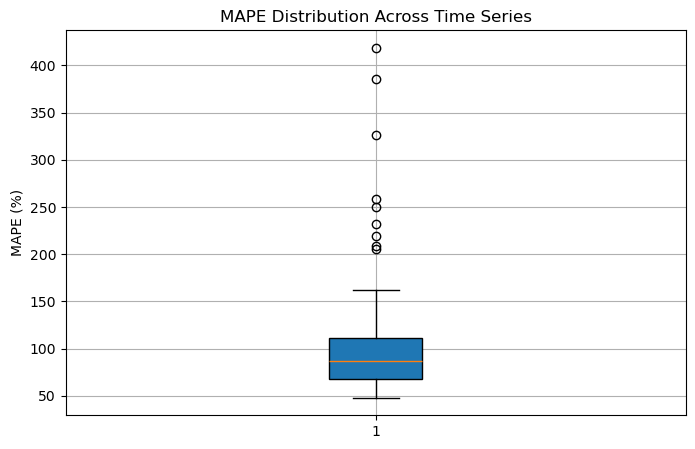

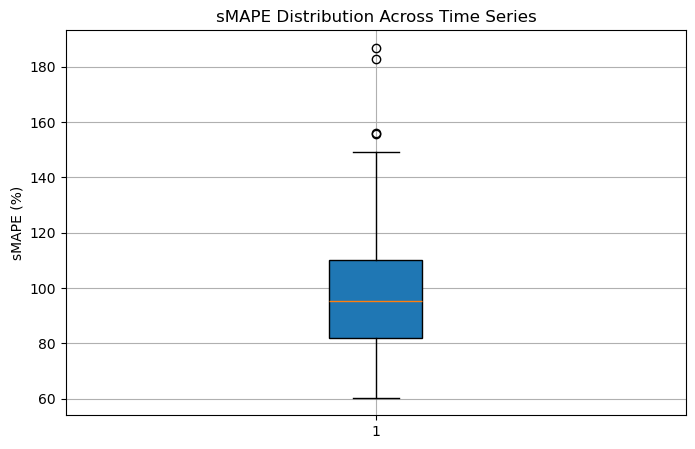

In [46]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

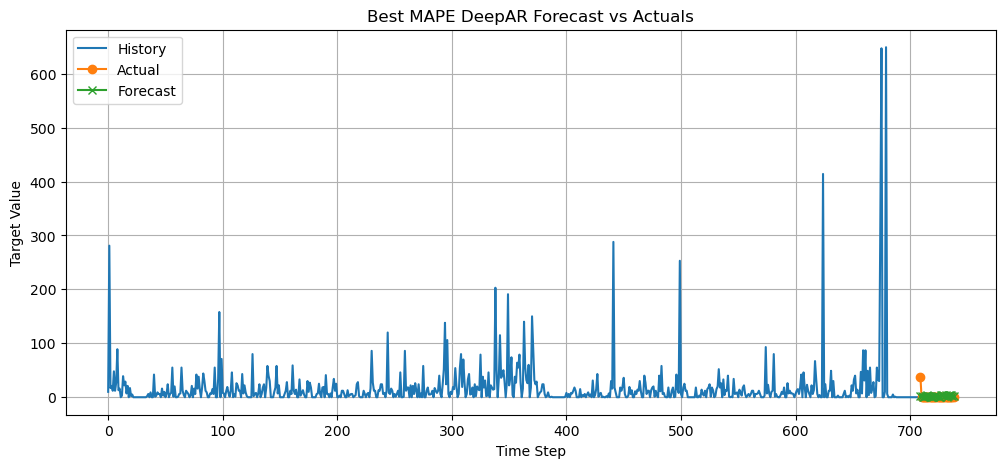

[38.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[1.98257146 2.48356285 0.         0.69789543 2.25272915 1.39614128
 3.3881316  2.64646047 1.36370012 0.         1.10314184 0.82666535
 2.36745365 2.16647771 2.30448039 1.60312349 0.08272356 1.28127788
 3.37357109 3.22314206 4.91633396 2.23945899 3.54741162 0.01209977
 1.50416304 3.22610129 3.52689588 3.46800093 3.07712778 1.66743365]


In [29]:
import matplotlib.pyplot as plt
series = data[30].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best sMAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

In [30]:
print(test_series[30])

{'start': '2009-12-01', 'target': [2.3978952727983707, 5.641907070938114, 2.8903717578961645, 3.0910424533583156, 2.5649493574615367, 3.8918202981106265, 2.5649493574615367, 3.332204510175204, 4.499809670330265, 2.6390573296152584, 2.833213344056216, 0.0, 1.3862943611198906, 3.6888794541139363, 3.1354942159291497, 3.4011973816621555, 2.0794415416798357, 3.0910424533583156, 0.0, 2.8903717578961645, 1.0986122886681096, 1.791759469228055, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0986122886681096, 1.9459101490553132, 0.0, 2.3025850929940455, 0.0, 0.0, 3.7612001156935624, 0.6931471805599453, 1.3862943611198906, 2.3025850929940455, 1.9459101490553132, 1.9459101490553132, 0.0, 2.833213344056216, 1.3862943611198906, 2.3978952727983707, 0.0, 2.0794415416798357, 3.2188758248682006, 0.0, 1.9459101490553132, 2.197224577336219, 4.025351690735149, 0.6931471805599453, 3.044522437723423, 0.0, 0.0, 0.6931471805599453, 1.9459101490553132, 2.0794415416798357, 4.025351690735149, 2.564

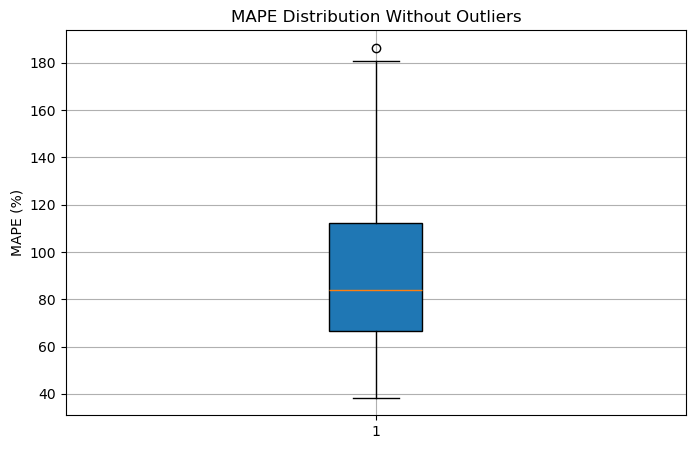

Average MAPE:  92.9633510667516


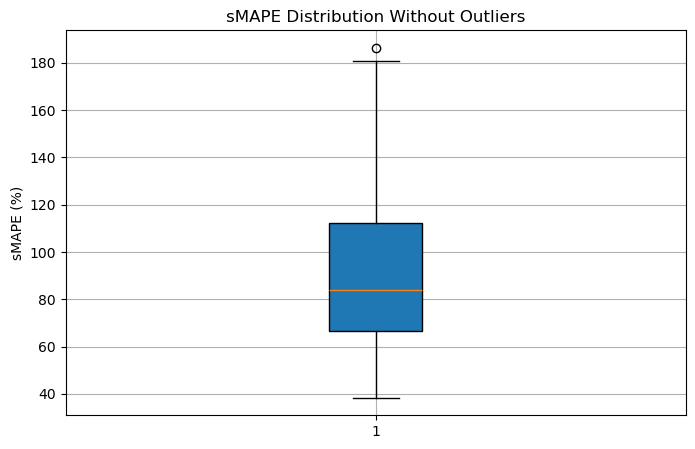

Average sMAPE:  89.81201508998373


In [34]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))

In [1]:
predictor.delete_endpoint()


NameError: name 'predictor' is not defined